## Abstract Problem Statement / Objective
#### " Spark Funds wants to invest where most investors are investing"
###### Data Source : crunchbase.com

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from collections import Counter

In [2]:
companies = pd.read_csv("data/companies.csv",encoding='palmos')
# companies.head(10)

In [3]:
rounds2 = pd.read_csv("data/rounds2.csv",encoding='palmos')
# rounds2.head(10)

#### First clean common column which we will use for joining

#### Data Swimming & Cleaning : I

In [4]:
#Data Cleaning
def normalize_text(s:str)-> str:
    '''
    Function to standardize Unique Ids of Companies/Rounds
    returns normalized string
    '''
    s = s.strip().lower()
    return s

#test function
normalize_text('/Organization/0Xdata')

'/organization/0xdata'

In [5]:
#Apply cleaning on common column
companies['permalink'] = companies.permalink.apply(lambda x:normalize_text(x))
rounds2['company_permalink'] = rounds2['company_permalink'].apply(lambda x:normalize_text(x))

## Checkpoints : Part 1

### Checkpoint 1 : Table 1.1

In [6]:
#1 How many unique companies are present in rounds2?
rounds2['company_permalink'].describe()#value_counts()

count                       114949
unique                       66368
top       /organization/solarflare
freq                            19
Name: company_permalink, dtype: object

In [7]:
#2 How many unique companies are present in the companies file?
companies['permalink'].describe()#value_counts()

count                                                 66368
unique                                                66368
top       /organization/advanced-materials-technology-in...
freq                                                      1
Name: permalink, dtype: object

In [8]:
#3 In the companies data frame, which column can be used as the  unique key for each company? Write the name of the column.
#Number of records == number of unique records ==> candidate for Primary key
companies.describe()
#Answer = permalink

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
count,66368,66367,61310,63220,66368,59410,57821,58338,58340,51147
unique,66368,66099,61191,27296,4,137,311,1092,5111,3978
top,/organization/advanced-materials-technology-in...,Spire,http://www.askforoffer.com,Software,operating,USA,CA,SF Bay Area,San Francisco,01-01-2012
freq,1,4,5,3995,53034,37601,12900,8804,3526,2730


In [9]:
#4 Are there any companies in the rounds2 file which are not  present in companies ? Answer Y/N.
companies_in_rounds2 = rounds2['company_permalink'].apply(lambda x:normalize_text(x)).values
companies_in_companies = companies.permalink.apply(lambda x:normalize_text(x)).values

list(set(companies_in_rounds2)-set(companies_in_companies))
#Answer = N

[]

In [10]:
#5 Merge the two data frames so that all  variables (columns)  in the companies frame are added to the rounds2 data frame. 
#Name the merged frame master_frame. How many observations are present in master_frame ?
print(list(companies.columns))
print(list(rounds2.columns))

['permalink', 'name', 'homepage_url', 'category_list', 'status', 'country_code', 'state_code', 'region', 'city', 'founded_at']
['company_permalink', 'funding_round_permalink', 'funding_round_type', 'funding_round_code', 'funded_at', 'raised_amount_usd']


In [11]:
master_frame = pd.merge(rounds2, companies, left_on='company_permalink',right_on='permalink', how='left')

In [12]:
master_frame.head(2)

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,05-01-2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014


In [13]:
rounds2.shape,companies.shape,master_frame.shape

((114949, 6), (66368, 10), (114949, 16))

In [14]:
# master_frame[master_frame['company_permalink']==master_frame['permalink']].shape

### Checkpoint 2 : Table 2.1

## Data Swimming & Cleaning : II

In [15]:
#check NA percentage per column
columns_of_interest = ['company_permalink','funding_round_permalink','funding_round_type','raised_amount_usd','name','category_list','country_code','status']
100*master_frame[columns_of_interest].isna().sum()/master_frame.shape[0]

company_permalink           0.000000
funding_round_permalink     0.000000
funding_round_type          0.000000
raised_amount_usd          17.390321
name                        0.000870
category_list               2.966533
country_code                7.549435
status                      0.000000
dtype: float64

In [16]:
#Drop columns which are off 'no interest/use' here in our problem
master_frame = master_frame[columns_of_interest]

#### As percentage of NA for 'raised_amount_usd' is >10%, we will drop  rows with 'raised_amount_usd'==NA

In [17]:
print(master_frame.shape)
master_frame = master_frame[~(master_frame['raised_amount_usd'].isna())]
print(master_frame.shape)

(114949, 8)
(94959, 8)


In [18]:
100*master_frame[columns_of_interest].isna().sum()/master_frame.shape[0]

company_permalink          0.000000
funding_round_permalink    0.000000
funding_round_type         0.000000
raised_amount_usd          0.000000
name                       0.001053
category_list              1.099422
country_code               6.161607
status                     0.000000
dtype: float64

#### As {'category_list','country_code'} are categorical variables, we may think of replacing them by most frequent value. But doing so won't e sensible, as it would result into wrong assignment of country_code/category. So, again we are going to drop them.

#### Same is true for 'name' column. 

In [19]:
print(master_frame.isna().sum())
master_frame = master_frame.dropna()
print(master_frame.isna().sum())

company_permalink             0
funding_round_permalink       0
funding_round_type            0
raised_amount_usd             0
name                          1
category_list              1044
country_code               5851
status                        0
dtype: int64
company_permalink          0
funding_round_permalink    0
funding_round_type         0
raised_amount_usd          0
name                       0
category_list              0
country_code               0
status                     0
dtype: int64


In [20]:
print(master_frame.shape)

(88528, 8)


In [21]:
114949-88528

26421

#### Let's look for data types

In [22]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88528 entries, 0 to 114947
Data columns (total 8 columns):
company_permalink          88528 non-null object
funding_round_permalink    88528 non-null object
funding_round_type         88528 non-null object
raised_amount_usd          88528 non-null float64
name                       88528 non-null object
category_list              88528 non-null object
country_code               88528 non-null object
status                     88528 non-null object
dtypes: float64(1), object(7)
memory usage: 6.1+ MB


#### We can see that, 'raised_amount_type' is of float type & rest are having expected data types. Now lets jump into the checkpoint questions ...

In [23]:
master_frame['funding_round_type'].value_counts()

venture                  47809
seed                     21094
debt_financing            6506
angel                     4400
grant                     1939
private_equity            1820
undisclosed               1345
convertible_note          1320
equity_crowdfunding       1128
post_ipo_equity            598
product_crowdfunding       330
post_ipo_debt              151
non_equity_assistance       60
secondary_market            28
Name: funding_round_type, dtype: int64

In [24]:
#1 Average funding amount of funding_type in {'venture','angel','seed','private_equity'}
for funding_type in ['venture','angel','seed','private_equity']:
    #without dropping NA
    avg = master_frame[master_frame['funding_round_type']==funding_type]['raised_amount_usd'].describe()['mean']
    print(funding_type,"|",avg,"|",avg/(1000000))

venture | 11724222.690204773 | 11.724222690204773
angel | 971573.8911363636 | 0.9715738911363636
seed | 747827.9478524699 | 0.7478279478524699
private_equity | 73938486.27527472 | 73.93848627527473


In [25]:
#checking medians vs mean of all

In [26]:
#Numbers are in millions USD
print("Funding_type|Median|Mean")
for funding_type in ['venture','angel','seed','private_equity']:
    t = master_frame[master_frame['funding_round_type']==funding_type]['raised_amount_usd']
    print(funding_type,"|",t.median()/(1000000),"|",t.mean()/(1000000))
    
print("\n(Remark : Numbers are in millions USD)")

Funding_type|Median|Mean
venture | 5.0 | 11.724222690204773
angel | 0.414906 | 0.9715738911363636
seed | 0.3 | 0.7478279478524699
private_equity | 20.0 | 73.93848627527473

(Remark : Numbers are in millions USD)


##### If we consider median amount of each funding_type, only 'venture' satisfies 5 to 15 mn USD condition.(Even if we consider mean, then also 'venture' will be the only choice. 

## Checkpoints - Part 2

### Checkpoint 3 : Table 3.1

In [27]:
master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,raised_amount_usd,name,category_list,country_code,status
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,10000000.0,#fame,Media,IND,operating
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,700000.0,:Qounter,Application Platforms|Real Time|Social Network...,USA,operating
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,2000000.0,0-6.com,Curated Web,CHN,operating
6,/organization/01games-technology,/funding-round/7d53696f2b4f607a2f2a8cbb83d01839,undisclosed,41250.0,01Games Technology,Games,HKG,operating
7,/organization/0ndine-biomedical-inc,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,43360.0,Ondine Biomedical Inc.,Biotechnology,CAN,operating


In [28]:
country_wise_data = master_frame[master_frame['funding_round_type']=='venture'].groupby(by='country_code')
aggregate = country_wise_data.sum()['raised_amount_usd'].sort_values(ascending=False)[:9]
data = np.array(list(zip(aggregate.index.values,aggregate.values)))
top9 = pd.DataFrame(data,columns=['country_code','total_raised_amount'])

In [29]:
top9

,country_code,total_raised_amount
0,USA,420068029342.0
1,CHN,39338918773.0
2,GBR,20072813004.0
3,IND,14261508718.0
4,CAN,9482217668.0
5,FRA,7226851352.0
6,ISR,6854350477.0
7,DEU,6306921981.0
8,JPN,3167647127.0


In [30]:
is_english_speaking = {'USA':True,'CHN':False,'GBR':True,'IND':True,'CAN':True,'FRA':False,'ISR':True,'DEU':False,'JPN':False}
data = np.array(list(zip(aggregate.index.values,aggregate.values)))
top9 = pd.DataFrame(data,columns=['country_code','total_raised_amount'])
top9['is_english_speaking'] = top9['country_code'].apply(lambda x: is_english_speaking.get(x,'UNKNOWN_YET'))
top9

,country_code,total_raised_amount,is_english_speaking
0,USA,420068029342.0,True
1,CHN,39338918773.0,False
2,GBR,20072813004.0,True
3,IND,14261508718.0,True
4,CAN,9482217668.0,True
5,FRA,7226851352.0,False
6,ISR,6854350477.0,True
7,DEU,6306921981.0,False
8,JPN,3167647127.0,False


In [31]:
top9[top9['is_english_speaking']==True]

,country_code,total_raised_amount,is_english_speaking
0,USA,420068029342.0,True
2,GBR,20072813004.0,True
3,IND,14261508718.0,True
4,CAN,9482217668.0,True
6,ISR,6854350477.0,True


#### Top 3 required countries in order : {USA,GBR,IND}

### Checkpoint 4: Sector Analysis 1

In [32]:
filtered_df = master_frame[(master_frame['country_code'].isin(['USA','GBR','IND'])) & (master_frame['funding_round_type']=='venture')]
filtered_df.shape

(38803, 8)

In [33]:
filtered_df['primary_sector'] = filtered_df['category_list'].apply(lambda x:str(x).strip().split('|')[0].lower())
# filtered_df.head()

C:\Users\gpatil1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
filtered_df['primary_sector'].isna().sum()

0

In [35]:
filtered_df['primary_sector'].value_counts()

biotechnology          5875
software               3345
advertising            1847
health care            1596
enterprise software    1560
                       ... 
online reservations       1
cosmetic surgery          1
synchronization           1
social fundraising        1
ebooks                    1
Name: primary_sector, Length: 563, dtype: int64

In [36]:
mapping_df = pd.read_csv('data/mapping.csv')
mapping_df[mapping_df['category_list'].isna()]

,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0


#### As there is only one row with NA value for 'category_list', we will drop that row.

### Data Cleaning & mapping_df preparation

In [37]:
for cat in mapping_df['category_list'].values:
    if '0' in str(cat) and '.0' not in str(cat):
        print(cat, end="|")

Alter0tive Medicine|A0lytics|Big Data A0lytics|Business A0lytics|Can0bis|Career Ma0gement|Chi0 Internet|Cloud Ma0gement|Contact Ma0gement|Digital Rights Ma0gement|Digital Sig0ge|Document Ma0gement|Educatio0l Games|Energy Ma0gement|Event Ma0gement|Fi0nce|Fi0nce Technology|Fi0ncial Exchanges|Fi0ncial Services|Fleet Ma0gement|Gover0nce|Identity Ma0gement|Innovation Ma0gement|Intellectual Asset Ma0gement|Investment Ma0gement|IT Ma0gement|Jour0lism|Knowledge Ma0gement|Lead Ma0gement|Medical Professio0ls|Mobile A0lytics|0notechnology|0tural Language Processing|0tural Resources|0vigation|Perso0l Branding|Perso0l Data|Perso0l Fi0nce|Perso0l Health|Perso0lization|Predictive A0lytics|Professio0l Networking|Professio0l Services|Project Ma0gement|Promotio0l|Property Ma0gement|Risk Ma0gement|Social Media Ma0gement|Supply Chain Ma0gement|Task Ma0gement|Veteri0ry|Waste Ma0gement|

#### from above observation, we will replace '0' with 'na' at proper places

In [38]:
mapping_df = pd.read_csv('data/mapping.csv')
mapping_df = mapping_df.dropna()

def clean_category_list(x):
    x = str(x).strip().lower()
    if '0' in x and '.0' not in str(cat):
        x = x.replace('0','na')
    return x

def get_main_sector(x):
    x = x.strip().lower()
    if x in category_list:
        try:
            i = list(mapping_df[mapping_df['category_list']==x].values[0]).index(1)
            return mapping_df.columns[i]
        except:
            pass#print("ERROR",x)
    return ''

mapping_df['category_list'] = mapping_df['category_list'].apply(lambda x: clean_category_list(x))
category_list = mapping_df['category_list'].values

mapping_df['main_sector'] = mapping_df['category_list'].apply(lambda x:get_main_sector(x)) 
mapping_df = mapping_df[['category_list','main_sector']]

mapping_df.head()
# filtered_df['main_sector'] = filtered_df['primary_sector'].apply(lambda x:get_main_sector(x))

,category_list,main_sector
1,3d,Manufacturing
2,3d printing,Manufacturing
3,3d technology,Manufacturing
4,accounting,"Social, Finance, Analytics, Advertising"
5,active lifestyle,Health


In [39]:
# mapping_df.category_list.values

In [40]:
# filtered_df.columns

In [41]:
# mapping_df.columns

In [42]:
master_df = filtered_df.merge(mapping_df,left_on='primary_sector',right_on='category_list',how='inner')

In [43]:
master_df.main_sector.value_counts()

Others                                     9110
Cleantech / Semiconductors                 8492
Social, Finance, Analytics, Advertising    7814
News, Search and Messaging                 4727
Health                                     3429
Manufacturing                              2630
Entertainment                              2006
Automotive & Sports                         580
Name: main_sector, dtype: int64

In [44]:
master_df.main_sector.str.lower().value_counts()

others                                     9110
cleantech / semiconductors                 8492
social, finance, analytics, advertising    7814
news, search and messaging                 4727
health                                     3429
manufacturing                              2630
entertainment                              2006
automotive & sports                         580
Name: main_sector, dtype: int64

### Hence, it's not required to do 'main_sector' normalization/standardization

In [45]:
master_df.shape

(38788, 11)

In [46]:
# new_master_df.columns

In [47]:
master_df.head()

,company_permalink,funding_round_permalink,funding_round_type,raised_amount_usd,name,category_list_x,country_code,status,primary_sector,category_list_y,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,10000000.0,#fame,Media,IND,operating,media,media,Entertainment
1,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,15000000.0,90min,Media|News|Publishing|Soccer|Sports,GBR,operating,media,media,Entertainment
2,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,5800000.0,90min,Media|News|Publishing|Soccer|Sports,GBR,operating,media,media,Entertainment
3,/organization/90min,/funding-round/fd4b15e8c97ee2ffc0acccdbe1a98810,venture,18000000.0,90min,Media|News|Publishing|Soccer|Sports,GBR,operating,media,media,Entertainment
4,/organization/all-def-digital,/funding-round/452a2342fe720285c3b92e9bd927d9ba,venture,5000000.0,All Def Digital,Media,USA,operating,media,media,Entertainment


### Checkpoint 5 : Sector Analysis 2

In [48]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38788 entries, 0 to 38787
Data columns (total 11 columns):
company_permalink          38788 non-null object
funding_round_permalink    38788 non-null object
funding_round_type         38788 non-null object
raised_amount_usd          38788 non-null float64
name                       38788 non-null object
category_list_x            38788 non-null object
country_code               38788 non-null object
status                     38788 non-null object
primary_sector             38788 non-null object
category_list_y            38788 non-null object
main_sector                38788 non-null object
dtypes: float64(1), object(10)
memory usage: 3.6+ MB


In [49]:
master_df.isna().sum()

company_permalink          0
funding_round_permalink    0
funding_round_type         0
raised_amount_usd          0
name                       0
category_list_x            0
country_code               0
status                     0
primary_sector             0
category_list_y            0
main_sector                0
dtype: int64

In [50]:
D1 = master_df[(master_df['country_code']=='USA')&(master_df['funding_round_type']=='venture')&(master_df['raised_amount_usd']<=15000000)&(master_df['raised_amount_usd']>=5000000)]
D2 = master_df[(master_df['country_code']=='GBR')&(master_df['funding_round_type']=='venture')&(master_df['raised_amount_usd']<=15000000)&(master_df['raised_amount_usd']>=5000000)]
D3 = master_df[(master_df['country_code']=='IND')&(master_df['funding_round_type']=='venture')&(master_df['raised_amount_usd']<=15000000)&(master_df['raised_amount_usd']>=5000000)]

# D1.head()

### Tale 5.1

##### Q 1-2

In [51]:
D1.shape,D2.shape,D3.shape

((12063, 11), (621, 11), (328, 11))

In [52]:
D1.raised_amount_usd.sum(),D2.raised_amount_usd.sum(),D3.raised_amount_usd.sum()

(107757097294.0, 5379078691.0, 2949543602.0)

#### Country wise stats

In [53]:
# current_df = D1
# current_df = D2
current_df = D3

In [54]:
current_df[['funding_round_type','country_code','main_sector']].describe()

,funding_round_type,country_code,main_sector
count,328,328,328
unique,1,1,8
top,venture,IND,Others
freq,328,328,110


In [55]:
current_df['raised_amount_usd'].describe()

count    3.280000e+02
mean     8.992511e+06
std      3.219811e+06
min      5.000000e+06
25%      6.000000e+06
50%      8.700000e+06
75%      1.055500e+07
max      1.500000e+07
Name: raised_amount_usd, dtype: float64

In [56]:
current_df.status.value_counts()

operating    292
acquired      17
closed        13
ipo            6
Name: status, dtype: int64

#### Q 3-8

In [57]:
aggregate = current_df.groupby('main_sector').count()['funding_round_permalink'].reset_index()
top_sectors = aggregate.sort_values(by='funding_round_permalink',ascending=False)
top_sectors

,main_sector,funding_round_permalink
6,Others,110
7,"Social, Finance, Analytics, Advertising",60
5,"News, Search and Messaging",52
2,Entertainment,33
4,Manufacturing,21
1,Cleantech / Semiconductors,20
3,Health,19
0,Automotive & Sports,13


In [58]:
# current_df.groupby('main_sector').sum().reset_index().sort_values(by='raised_amount_usd',ascending=False)

#### Q 9-10

In [59]:
main_sector_ = top_sectors.iloc[0,0]
print(top_sectors.iloc[0,0])

fundings_in_that_sector = current_df[current_df.main_sector==main_sector_][['raised_amount_usd','company_permalink','name','main_sector']]
total_fundings = fundings_in_that_sector.groupby('company_permalink').sum().reset_index().sort_values(by='raised_amount_usd',ascending=False)
top5_companies = total_fundings.head()
top5_companies

Others


,company_permalink,raised_amount_usd
27,/organization/firstcry-com,39000000.0
48,/organization/myntra,38000000.0
16,/organization/commonfloor,32900000.0
60,/organization/pepperfry-com,28000000.0
40,/organization/itzcash-card-ltd,25000000.0


In [60]:
current_df[current_df['company_permalink']==top5_companies.iloc[0,0]][['company_permalink','name','status','country_code']]

,company_permalink,name,status,country_code
20631,/organization/firstcry-com,FirstCry.com,operating,IND
20632,/organization/firstcry-com,FirstCry.com,operating,IND
20633,/organization/firstcry-com,FirstCry.com,operating,IND


In [61]:
main_sector_ = top_sectors.iloc[1,0]
print(top_sectors.iloc[1,0])
fundings_in_that_sector = current_df[current_df.main_sector==main_sector_][['raised_amount_usd','company_permalink','name','main_sector']]
total_fundings = fundings_in_that_sector.groupby('company_permalink').sum().reset_index().sort_values(by='raised_amount_usd',ascending=False)
top5_companies = total_fundings.head()
top5_companies

Social, Finance, Analytics, Advertising


,company_permalink,raised_amount_usd
31,/organization/manthan-systems,50700000.0
28,/organization/komli-media,28000000.0
41,/organization/shopclues-com,25000000.0
27,/organization/intarvo,21900000.0
22,/organization/grameen-financial-services,21556050.0


In [62]:
current_df[current_df['company_permalink']==top5_companies.iloc[0,0]][['company_permalink','name','status','country_code']]

,company_permalink,name,status,country_code
741,/organization/manthan-systems,Manthan Systems,operating,IND
742,/organization/manthan-systems,Manthan Systems,operating,IND
744,/organization/manthan-systems,Manthan Systems,operating,IND
745,/organization/manthan-systems,Manthan Systems,operating,IND


#### Answers to Q9-10:
    1) C1(USA) : Virtustream | SST Inc. (Formerly ShotSpotter)
    2) C2(GBR) : Electric Cloud | Celltick Technologies
    3) C3(INR) : FirstCry.com | Manthan Systems	

### Checkpoint 6 

#### Plot 1

In [63]:
master_frame.country_code.unique()

array(['IND', 'USA', 'CHN', 'HKG', 'CAN', 'CHL', 'GBR', 'FRA', 'AUS',
       'ROM', 'KOR', 'NLD', 'SWE', 'RUS', 'DNK', 'NOR', 'COL', 'ESP',
       'BEL', 'IRL', 'ITA', 'ISR', 'SGP', 'NZL', 'CHE', 'BRA', 'SVN',
       'JOR', 'HUN', 'JPN', 'BWA', 'DEU', 'NGA', 'FIN', 'CYP', 'CRI',
       'IDN', 'PRT', 'ARG', 'TWN', 'THA', 'SVK', 'UKR', 'LTU', 'ISL',
       'MEX', 'TUR', 'VEN', 'URY', 'AUT', 'KEN', 'ZAF', 'PHL', 'MNE',
       'MYS', 'PER', 'POL', 'EGY', 'PAN', 'LVA', 'GGY', 'VNM', 'UGA',
       'HRV', 'EST', 'BGR', 'MUS', 'LBN', 'GRC', 'NPL', 'LUX', 'CZE',
       'ARE', 'SAU', 'PAK', 'IRN', 'ALB', 'BAH', 'ARM', 'BGD', 'MDA',
       'GHA', 'TUN', 'ZWE', 'BRB', 'NIC', 'TAN', 'TTO', 'CMR', 'SRB',
       'PRI', 'BLR', 'CYM', 'ECU', 'SLV', 'MLT', 'GTM', 'ZMB', 'GIB',
       'BHR', 'TGO', 'BMU', 'HND', 'MCO', 'MMR', 'KAZ', 'QAT', 'MAR',
       'LIE', 'GEO', 'DOM', 'DZA', 'JAM', 'KNA', 'AZE', 'SEN', 'RWA',
       'DMA', 'UZB', 'BLZ', 'OMN', 'PSE', 'KWT', 'KHM', 'CIV', 'BLM',
       'GRD', 'LAO',

In [64]:
master_frame.funding_round_type.unique()

array(['venture', 'seed', 'undisclosed', 'convertible_note',
       'private_equity', 'debt_financing', 'angel', 'grant',
       'equity_crowdfunding', 'post_ipo_equity', 'post_ipo_debt',
       'product_crowdfunding', 'secondary_market',
       'non_equity_assistance'], dtype=object)

In [65]:
data = master_frame.groupby('funding_round_type').count().reset_index()
data['fraction_of_total_investments'] = data['funding_round_permalink']/data['funding_round_permalink'].sum()
plot_data_count = data[data.funding_round_type.isin(['angel','venture','seed','private_equity'])]
plot_data_count

,funding_round_type,company_permalink,funding_round_permalink,raised_amount_usd,name,category_list,country_code,status,fraction_of_total_investments
0,angel,4400,4400,4400,4400,4400,4400,4400,0.049702
8,private_equity,1820,1820,1820,1820,1820,1820,1820,0.020558
11,seed,21094,21094,21094,21094,21094,21094,21094,0.238275
13,venture,47809,47809,47809,47809,47809,47809,47809,0.540044


In [66]:
def get_count(x):
    return plot_data_count[plot_data_count['funding_round_type']==x[0]]['funding_round_permalink'].values[0]

data = master_frame.groupby('funding_round_type').sum().reset_index()
# data['fraction'] = data['raised_amount_usd'].sum()
plot_data_amount = data[data.funding_round_type.isin(['angel','venture','seed','private_equity'])]
plot_data_amount['count'] = plot_data_amount.apply(lambda x:get_count(x),axis=1)
plot_data_amount['avg_fund_usd'] = plot_data_amount['raised_amount_usd']/plot_data_amount['count']
plot_data_amount

C:\Users\gpatil1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\gpatil1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,funding_round_type,raised_amount_usd,count,avg_fund_usd
0,angel,4.274925e+09,4400,9.715739e+05
8,private_equity,1.345680e+11,1820,7.393849e+07
11,seed,1.577468e+10,21094,7.478279e+05
13,venture,5.605234e+11,47809,1.172422e+07


C:\Users\gpatil1\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


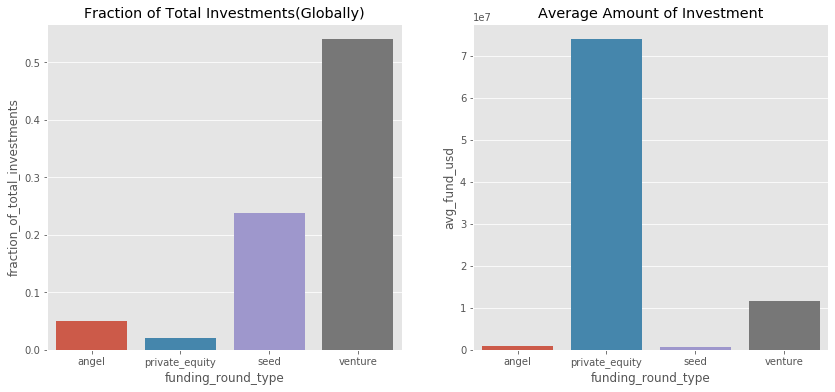

In [67]:
fig, ax =plt.subplots(1,2,figsize=(14,6))

plot_1 = sns.barplot(data=plot_data_count,x='funding_round_type',y='fraction_of_total_investments',ax=ax[0])
plot_1.set(title="Fraction of Total Investments(Globally)")

plot_2 = sns.barplot(data=plot_data_amount,x='funding_round_type',y='avg_fund_usd',ax=ax[1])
plot_2.set(title="Average Amount of Investment")

fig.show()

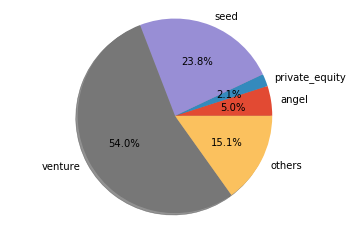

In [68]:
fig1, ax1 = plt.subplots()
weights = list(plot_data_count['fraction_of_total_investments'])+[1-sum(plot_data_count['fraction_of_total_investments'])]
labels = list(plot_data_count['funding_round_type']) +['others']
ax1.pie(weights, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()

In [69]:
weights,labels

([0.04970178926441352,
  0.020558467377552864,
  0.238274896078077,
  0.5400438279414422,
  0.15142101933851437],
 ['angel', 'private_equity', 'seed', 'venture', 'others'])

### From above plot, it's very clear that :
        1) Most investments are being made into 'venture' type
        2) Most total funding is being raised by 'private_equity' segment

#### Plot 2

In [70]:
top9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 3 columns):
country_code           9 non-null object
total_raised_amount    9 non-null object
is_english_speaking    9 non-null bool
dtypes: bool(1), object(2)
memory usage: 281.0+ bytes


In [71]:
top9.to_excel('submission/top9.xlsx',index=False)

In [72]:
top9['total_raised_amount'] = top9['total_raised_amount'].astype('float')

[Text(0.5, 1.0, ' Total amount of investments in Venture FT - Top 9 Countries')]

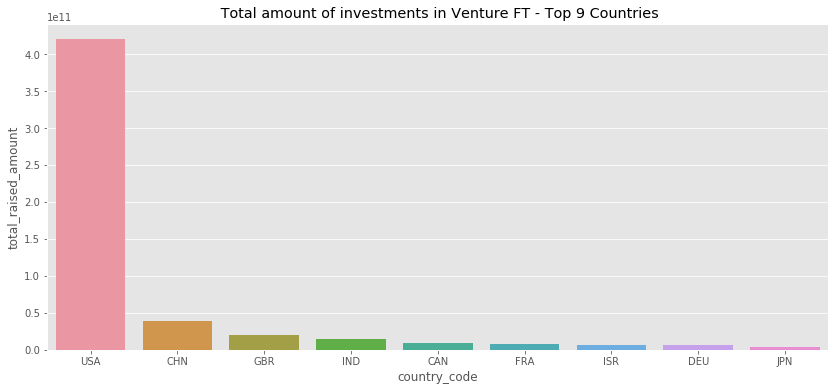

In [73]:
plt.figure(figsize=(14,6))
sns.barplot(data=top9,x='country_code',y='total_raised_amount').set(title=' Total amount of investments in Venture FT - Top 9 Countries')

### From above plot, it's very clear that :
    Top 3 required english speaking countries are:
        1) USA
        2) GBR
        3) IND

#### Plot 3

In [74]:
usa_data = D1.groupby('main_sector').count()['funding_round_permalink'].reset_index().sort_values('funding_round_permalink',ascending=False).head(3)
gbr_data = D2.groupby('main_sector').count()['funding_round_permalink'].reset_index().sort_values('funding_round_permalink',ascending=False).head(3)
ind_data = D3.groupby('main_sector').count()['funding_round_permalink'].reset_index().sort_values('funding_round_permalink',ascending=False).head(3)
usa_data,gbr_data,ind_data
# usa_data

(                               main_sector  funding_round_permalink
 6                                   Others                     2950
 7  Social, Finance, Analytics, Advertising                     2714
 1               Cleantech / Semiconductors                     2350,
                                main_sector  funding_round_permalink
 6                                   Others                      147
 7  Social, Finance, Analytics, Advertising                      133
 1               Cleantech / Semiconductors                      130,
                                main_sector  funding_round_permalink
 6                                   Others                      110
 7  Social, Finance, Analytics, Advertising                       60
 5               News, Search and Messaging                       52)

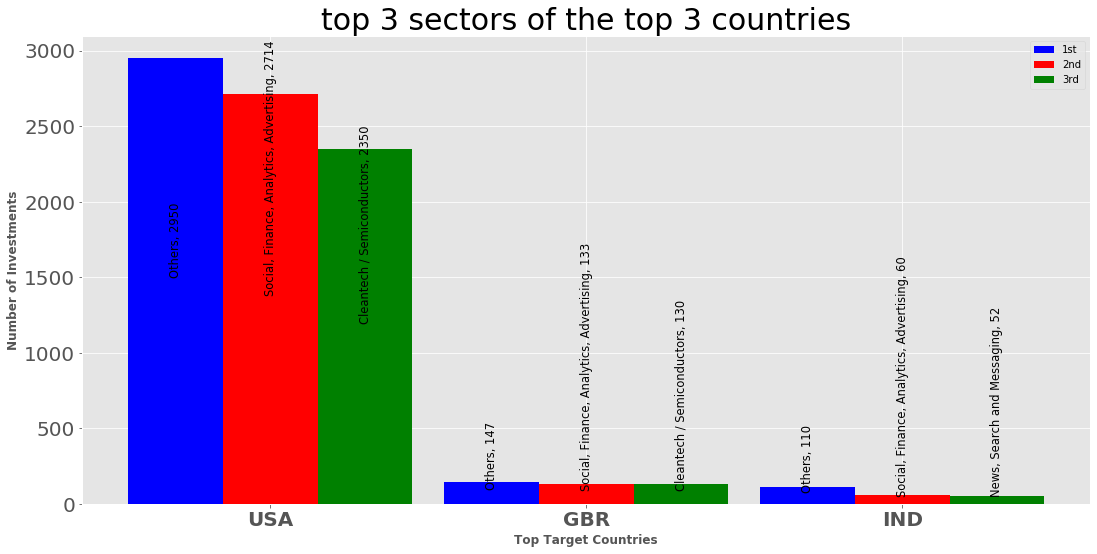

In [75]:
x_ = ['USA','GBR','IND']

x1 = [usa_data.iloc[0,0],gbr_data.iloc[0,0],ind_data.iloc[0,0]]
x2 =[usa_data.iloc[1,0],gbr_data.iloc[1,0],ind_data.iloc[1,0]]
x3 =[usa_data.iloc[2,0],gbr_data.iloc[2,0],ind_data.iloc[2,0]]

y = [usa_data.iloc[0,1],gbr_data.iloc[0,1],ind_data.iloc[0,1]]
y2 =[usa_data.iloc[1,1],gbr_data.iloc[1,1],ind_data.iloc[1,1]]
y3 =[usa_data.iloc[2,1],gbr_data.iloc[2,1],ind_data.iloc[2,1]]


fig = plt.figure(figsize=(14,6.5))
ax = fig.add_axes([0,0,1,1])

barWidth =0.3
r1 = np.arange(len(x_))
r2 = [i-(barWidth) for i in r1]
r3 = [i+(barWidth)  for i in r1]


rects1 = ax.bar(r2, y, width=barWidth, color='b', align='center',label='1st')
rects2 = ax.bar(r1, y2, width=barWidth, color='r', align='center',label='2nd')
rects3 = ax.bar(r3, y3, width=barWidth, color='g', align='center',label='3rd')

# rects1 = ax.barh(r2, y, height=barWidth, color='b', align='center',label='1st')
# rects2 = ax.barh(r1, y2, height=barWidth, color='r', align='center',label='2nd')
# rects3 = ax.barh(r3, y3, height=barWidth, color='g', align='center',label='3rd')

def autolabel(rects,arg):
    """Attach a text label above each bar in *rects*, displaying its height."""
    x=[]
    if arg==1:
        x=x1
    elif arg==2:
        x=x2
    else:
        x=x3
    
    for i,rect in enumerate(rects):
        height = rect.get_height()
        ax.annotate('{}'.format(x[i]+", "+str(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height/2),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',rotation=90,fontsize=11.5)



plt.xlabel('Top Target Countries', fontweight='bold')
plt.ylabel('Number of Investments', fontweight='bold')

plt.xticks(r1, x_,fontweight='bold')
# plt.xticks(r2, x)
# plt.xticks(r1, x2)
# plt.xticks(r3, x3)
# Create legend & Show graphic
plt.legend()
plt.xticks(rotation=0,fontsize=20)
plt.yticks(fontsize=20)
plt.title('top 3 sectors of the top 3 countries',fontsize=30)

autolabel(rects1,1)
autolabel(rects2,2)
autolabel(rects3,3)

plt.show()

### From above plot, we can have comparative look at top 3 sectors for each of the top 3 countries